In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

# analysis parameters
data_file = "GECC FYP Survey.csv"

In [2]:
# setup dataframe

# read file
df = pd.read_csv(data_file, error_bad_lines=False)

'''
    rename columns to readable format
    activity_1 = join for student club / organization / student union
    activity_2 = exco for student club / organization / student union
'''
df.columns = [
    "time", 
    "gender", 
    "age", 
    "local_or_non_local", 
    "nationality_current", # voided
    "university", 
    "current_study", 
    "year_of_study", 
    "drinking_frequency", 
    "drinking_consumption_amount", 
    "drinking_frequency_six_servings", 
    "type_of_drink",
    "drinking_occasion", 
    "attention_test", 
    "drinking_frequency_before_examination", 
    "gpa", 
    "activity_1", 
    "activity_2", 
    "academic_achievements", 
    "professional_examinations", 
    "nationality_extra" # voided
    # nationality
]

# fix nationality columns
df["nationality"] = df.nationality_current.combine_first(df.nationality_extra)
df.loc[ df["nationality"] == "Malaysian 馬來西亞", "nationality" ] = "Malaysia"
df.loc[ df["nationality"] == "Philippine 菲律賓", "nationality" ] = "Philipine"
df.loc[ df["nationality"] == "Indonesian 印尼", "nationality" ] = "Indonesia"
df.drop(columns=["nationality_current", "nationality_extra"], inplace=True)

# filter based on valid response
df = df.loc[ df["attention_test"] == "Italian 義式" ]
df = df.loc[ df["gpa"] > 1 ]
df = df.loc[ (df.drinking_consumption_amount == 0) | ~(df.drinking_frequency == "Never 從來不飲用") ]
df = df.loc[ ~(df["university"] == "UCL") ]

# drop unnecessary columns
df.drop(columns=["time", "attention_test"], inplace=True)

df.head()


/opt/anaconda3/envs/gecc-fyp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,gender,age,local_or_non_local,university,current_study,year_of_study,drinking_frequency,drinking_consumption_amount,drinking_frequency_six_servings,type_of_drink,drinking_occasion,drinking_frequency_before_examination,gpa,activity_1,activity_2,academic_achievements,professional_examinations,nationality
1,Male 男性,20,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,Monthly or less 少於每月,7.0,Less than once per month 少於每月,Soju 燒酒,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.67,Yes 有,Yes 有,6,0.0,Philipine
2,Male 男性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-4 times a month 每月二至四次,3.0,Less than once per month 少於每月,Soju 燒酒,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.33,Yes 有,Yes 有,5,0.0,Indonesia
4,Male 男性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-4 times a month 每月二至四次,2.0,Less than once per month 少於每月,Soju 燒酒,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.55,Yes 有,No 沒有,4,0.0,Indonesia
5,Female 女性,21,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-4 times a month 每月二至四次,3.0,Less than once per month 少於每月,Cocktails,"Special events (birthdays, graduation, etc.) 特...",Never (0%) 從來不會,3.50,Yes 有,No 沒有,6,0.0,Indonesia
6,Male 男性,20,Non-local student 非本地生,The Chinese University of Hong Kong (CUHK) 香港中文大學,Undergraduate student 本科生,4 or above 四年級以上,2-3 times a week 每週二至三次,3.0,Weekly 每週,Whiskey 威士忌,"Special events (birthdays, graduation, etc.) 特...",Occasionally (20%) 偶爾,3.60,Yes 有,No 沒有,2,0.0,Taiwan


In [3]:
df_non_drinker  = df.loc[ df["drinking_consumption_amount"] == 0]
df_drinker = df.loc[ ~(df["drinking_consumption_amount"] == 0)]

print("Number of non drinker", len(df_non_drinker))
print("Number of drinker", len(df_drinker))

Number of non drinker 27
Number of drinker 115


In [4]:
# general overview drinker vs non drinker

# gender
df_non_drinker_gender = df_non_drinker.groupby("gender").size().reset_index()
df_drinker_gender = df_drinker.groupby("gender").size().reset_index()

print(df_non_drinker_gender)
print()
print(df_drinker_gender)


      gender   0
0  Female 女性  15
1    Male 男性  12

                    gender   0
0                Female 女性  54
1                  Male 男性  59
2  Prefer not to say 不方便透露   2


In [5]:
# year of study
df_non_drinker_year_of_study = df_non_drinker.groupby("year_of_study").size().reset_index()
df_drinker_year_of_study = df_drinker.groupby("year_of_study").size().reset_index()

print(df_non_drinker_year_of_study)
print()
print(df_drinker_year_of_study)

      year_of_study   0
0                 1   1
1                 2   4
2                 3   9
3  4 or above 四年級以上  13

      year_of_study   0
0                 1   4
1                 2  21
2                 3  34
3  4 or above 四年級以上  56


In [6]:
# nationality
df_non_drinker_nationality = df_non_drinker.groupby("nationality").size().reset_index()
df_drinker_nationality = df_drinker.groupby("nationality").size().reset_index()

print(df_non_drinker_nationality)
print()
print(df_drinker_nationality)


  nationality   0
0       China   4
1   Hong Kong  13
2       India   3
3   Indonesia   1
4  Kazakhstan   1
5      Taiwan   1
6    Thailand   4

      nationality   0
0           China   5
1       Hong Kong  46
2           India   3
3       Indonesia  31
4      Kazakhstan   1
5    Korea, South   9
6        Malaysia   2
7       Philipine   1
8          Russia   1
9          Taiwan  14
10  United States   2


# Hypothesis Testing (Drinker vs. Non Drinker) t-Test
Hypothesis testing using z value since sample size is assumed to be large and the level of significance will be 5%

$H_0$: average gpa of drinker and non drinker are similar

$H_1$: average gpa of drinker and non drinker are different

since significance level is 5%, the z-score that is expected to satisfied the null hyphothesis should be $\pm$ 1.96 (two-tailed test critical value), where the z-score can be calculated as follow:

$$
    Z_s = \frac{X-\bar{X}}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}
$$

In [7]:
non_drinker_mean_gpa = df_non_drinker["gpa"].mean()
non_drinker_std_gpa = df_non_drinker["gpa"].std()
non_drinker_size = len(df_non_drinker["gpa"].dropna())

drinker_mean_gpa = df_drinker["gpa"].mean()
drinker_std_gpa = df_drinker["gpa"].std()
drinker_size = len(df_drinker["gpa"])

z_score_gpa_drink = (non_drinker_mean_gpa - drinker_mean_gpa) / (np.sqrt( non_drinker_std_gpa**2 / non_drinker_size + drinker_std_gpa**2 / drinker_size))
print(z_score_gpa_drink)


2.255281134922624


result of the z score is 2.255 which is in the range of rejection of null hypothesis. Therefore, we can conclude that we non drinker has higher gpa than drinker

p-value = 0.024121

In [8]:
z_score_academic_achievement = (df_non_drinker["academic_achievements"].mean() - df_drinker["academic_achievements"].mean()) / (np.sqrt( df_non_drinker["academic_achievements"].std()**2 / len(df_non_drinker["academic_achievements"]) + df_drinker["academic_achievements"].std()**2 / len(df_drinker["academic_achievements"])))
z_score_professional_examinations = (df_non_drinker["professional_examinations"].mean() - df_drinker["professional_examinations"].mean()) / (np.sqrt( df_non_drinker["professional_examinations"].std()**2 / len(df_non_drinker["professional_examinations"]) + df_drinker["professional_examinations"].std()**2 / len(df_drinker["professional_examinations"])))
print(z_score_academic_achievement)
print(z_score_professional_examinations)

0.018777567014033606
1.2266339932404553


result of z-score for both academic achievements and professional examinations are within the acceptance range for null hypothesis. Therefore we can conclude that there is no difference between drinkers and non drinkers.

academic achievements p-value = 0.98508

prof examinations p-value = 0.219973


# Quantifying categorical values

In [9]:
df_drinker_quantified = df_drinker.copy()

df_drinker_quantified.loc[ df.year_of_study == "4 or above 四年級以上", "year_of_study" ] = 4.0

def classification_drinking_consumption_amount_score(serving):
    if serving <= 2:
        return 1
    elif serving <= 4:
        return 2
    elif serving <= 6:
        return 3
    elif serving <= 9:
        return 4
    else:
        return 5


def classification_drinking_frequency_score(frequency):
    classification = {
        "Monthly or less 少於每月": 1,
        "Monthly or less 少於一個月": 1,
        "2-4 times a month 每月二至四次": 2,
        "2-3 times a week 每週二至三次": 3,
        "4 or more times a week 每週四次以上": 4
    }
    return classification[frequency]


def classification_drinking_frequency_six_servings_score(frequency):
    classification = {
        "Never 從來不會": 0,
        "Less than once per month 少於一個月": 1,
        "Less than once per month 少於每月": 1,
        "Monthly 每月": 2,
        "Weekly 每週": 3,
        "Daily or almost daily 每天或幾乎每天": 4
    }
    return classification[frequency]


def classification_drinking_frequency_before_examination_score(frequency):
    classification = {
        "Never (0%) 從來不會": 0,
        "Occasionally (20%) 偶爾": 1,
        "Sometimes (40%) 有時": 2,
        "Often (60%) 經常": 3,
        "Usually (80%) 通常": 4,
        "Always (100%) 總是": 5
    }
    return classification[frequency]


df_drinker_quantified = df_drinker_quantified.assign(drinking_consumption_amount_score=df_drinker_quantified.drinking_consumption_amount.apply(classification_drinking_consumption_amount_score)) 
df_drinker_quantified = df_drinker_quantified.assign(drinking_frequency_score=df_drinker_quantified.drinking_frequency.apply(classification_drinking_frequency_score))
df_drinker_quantified = df_drinker_quantified.assign(drinking_frequency_six_servings_score=df_drinker_quantified.drinking_frequency_six_servings.apply(classification_drinking_frequency_six_servings_score))
df_drinker_quantified = df_drinker_quantified.assign(drinking_frequency_before_examination_score=df_drinker_quantified.drinking_frequency_before_examination.apply(classification_drinking_frequency_before_examination_score))
df_drinker_quantified = df_drinker_quantified.assign()

df_drinker_quantified.loc[ df_drinker_quantified.activity_1 == "Yes 有", "activity_1" ] = 1.0
df_drinker_quantified.loc[ df_drinker_quantified.activity_1 == "No 沒有", "activity_1" ] = 0

df_drinker_quantified.loc[ df_drinker_quantified.activity_2 == "Yes 有", "activity_2" ] = 1.0
df_drinker_quantified.loc[ df_drinker_quantified.activity_2 == "No 沒有", "activity_2" ] = 0

quantified_columns = [
    "year_of_study", "drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score", "drinking_frequency_before_examination_score", 
    "gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"
]
df_drinker_quantified = df_drinker_quantified[quantified_columns]

In [10]:
# get overall score
df_drinker_quantified = df_drinker_quantified.assign(
    risk_score=(df_drinker_quantified.drinking_consumption_amount_score + 
                df_drinker_quantified.drinking_frequency_score + 
                df_drinker_quantified.drinking_frequency_six_servings_score + 
                df_drinker_quantified.drinking_frequency_before_examination_score
    )
)

def classification_risk_score_category(score):
    if score <= 3:
        return "Low"
    elif score <= 6:
        return "Increasing"
    elif score <= 9:
        return "Harmful"
    else:
        return "Dependence"


df_drinker_quantified = df_drinker_quantified.assign(risk_score_category=df_drinker_quantified.risk_score.apply(classification_risk_score_category))


df_drinker_quantified

,year_of_study,drinking_frequency_score,drinking_consumption_amount_score,drinking_frequency_six_servings_score,drinking_frequency_before_examination_score,gpa,activity_1,activity_2,academic_achievements,professional_examinations,risk_score,risk_score_category
1,4.0,1,4,1,0,3.67,1.0,1.0,6,0.0,6,Increasing
2,4.0,2,2,1,0,3.33,1.0,1.0,5,0.0,5,Increasing
4,4.0,2,1,1,0,3.55,1.0,0,4,0.0,4,Increasing
5,4.0,2,2,1,0,3.50,1.0,0,6,0.0,5,Increasing
6,4.0,3,2,3,1,3.60,1.0,0,2,0.0,9,Harmful
...,...,...,...,...,...,...,...,...,...,...,...,...
184,4.0,2,3,2,0,3.20,0,0,0,0.0,7,Harmful
185,4.0,2,2,1,0,3.45,0,0,0,0.0,5,Increasing
186,3,2,3,2,0,2.90,1.0,0,0,0.0,7,Harmful
187,4.0,3,2,3,0,3.50,1.0,1.0,1,0.0,8,Harmful


In [11]:
df_drinker_quantified.year_of_study = pd.to_numeric(df_drinker_quantified.year_of_study)
df_drinker_quantified.drinking_frequency_score = pd.to_numeric(df_drinker_quantified.drinking_frequency_score)
df_drinker_quantified.drinking_consumption_amount_score = pd.to_numeric(df_drinker_quantified.drinking_consumption_amount_score)
df_drinker_quantified.drinking_frequency_six_servings_score = pd.to_numeric(df_drinker_quantified.drinking_frequency_six_servings_score)
df_drinker_quantified.drinking_frequency_before_examination_score = pd.to_numeric(df_drinker_quantified.drinking_frequency_before_examination_score)
df_drinker_quantified.activity_1 = pd.to_numeric(df_drinker_quantified.activity_1)
df_drinker_quantified.activity_2 = pd.to_numeric(df_drinker_quantified.activity_2)

attribute_correlation = df_drinker_quantified.corr(method='pearson')


In [12]:
col_corr = ["gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"]
row_corr = ["drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score", "drinking_frequency_before_examination_score", "risk_score"]

attribute_correlation.loc[row_corr, col_corr]

,gpa,activity_1,activity_2,academic_achievements,professional_examinations
drinking_frequency_score,-0.221412,-0.036534,-0.214689,-0.155468,-0.116821
drinking_consumption_amount_score,-0.192091,-0.034054,-0.039336,-0.004066,-0.086259
drinking_frequency_six_servings_score,-0.162179,0.026622,-0.192759,-0.089608,-0.056415
drinking_frequency_before_examination_score,-0.241182,-0.130807,-0.104381,-0.154509,0.027700
risk_score,-0.283801,-0.054773,-0.180679,-0.123781,-0.086686


3.424043139280612
[ 0.04367911 -0.01523957 -0.00735863  0.03410499 -0.04519663 -0.03368985]


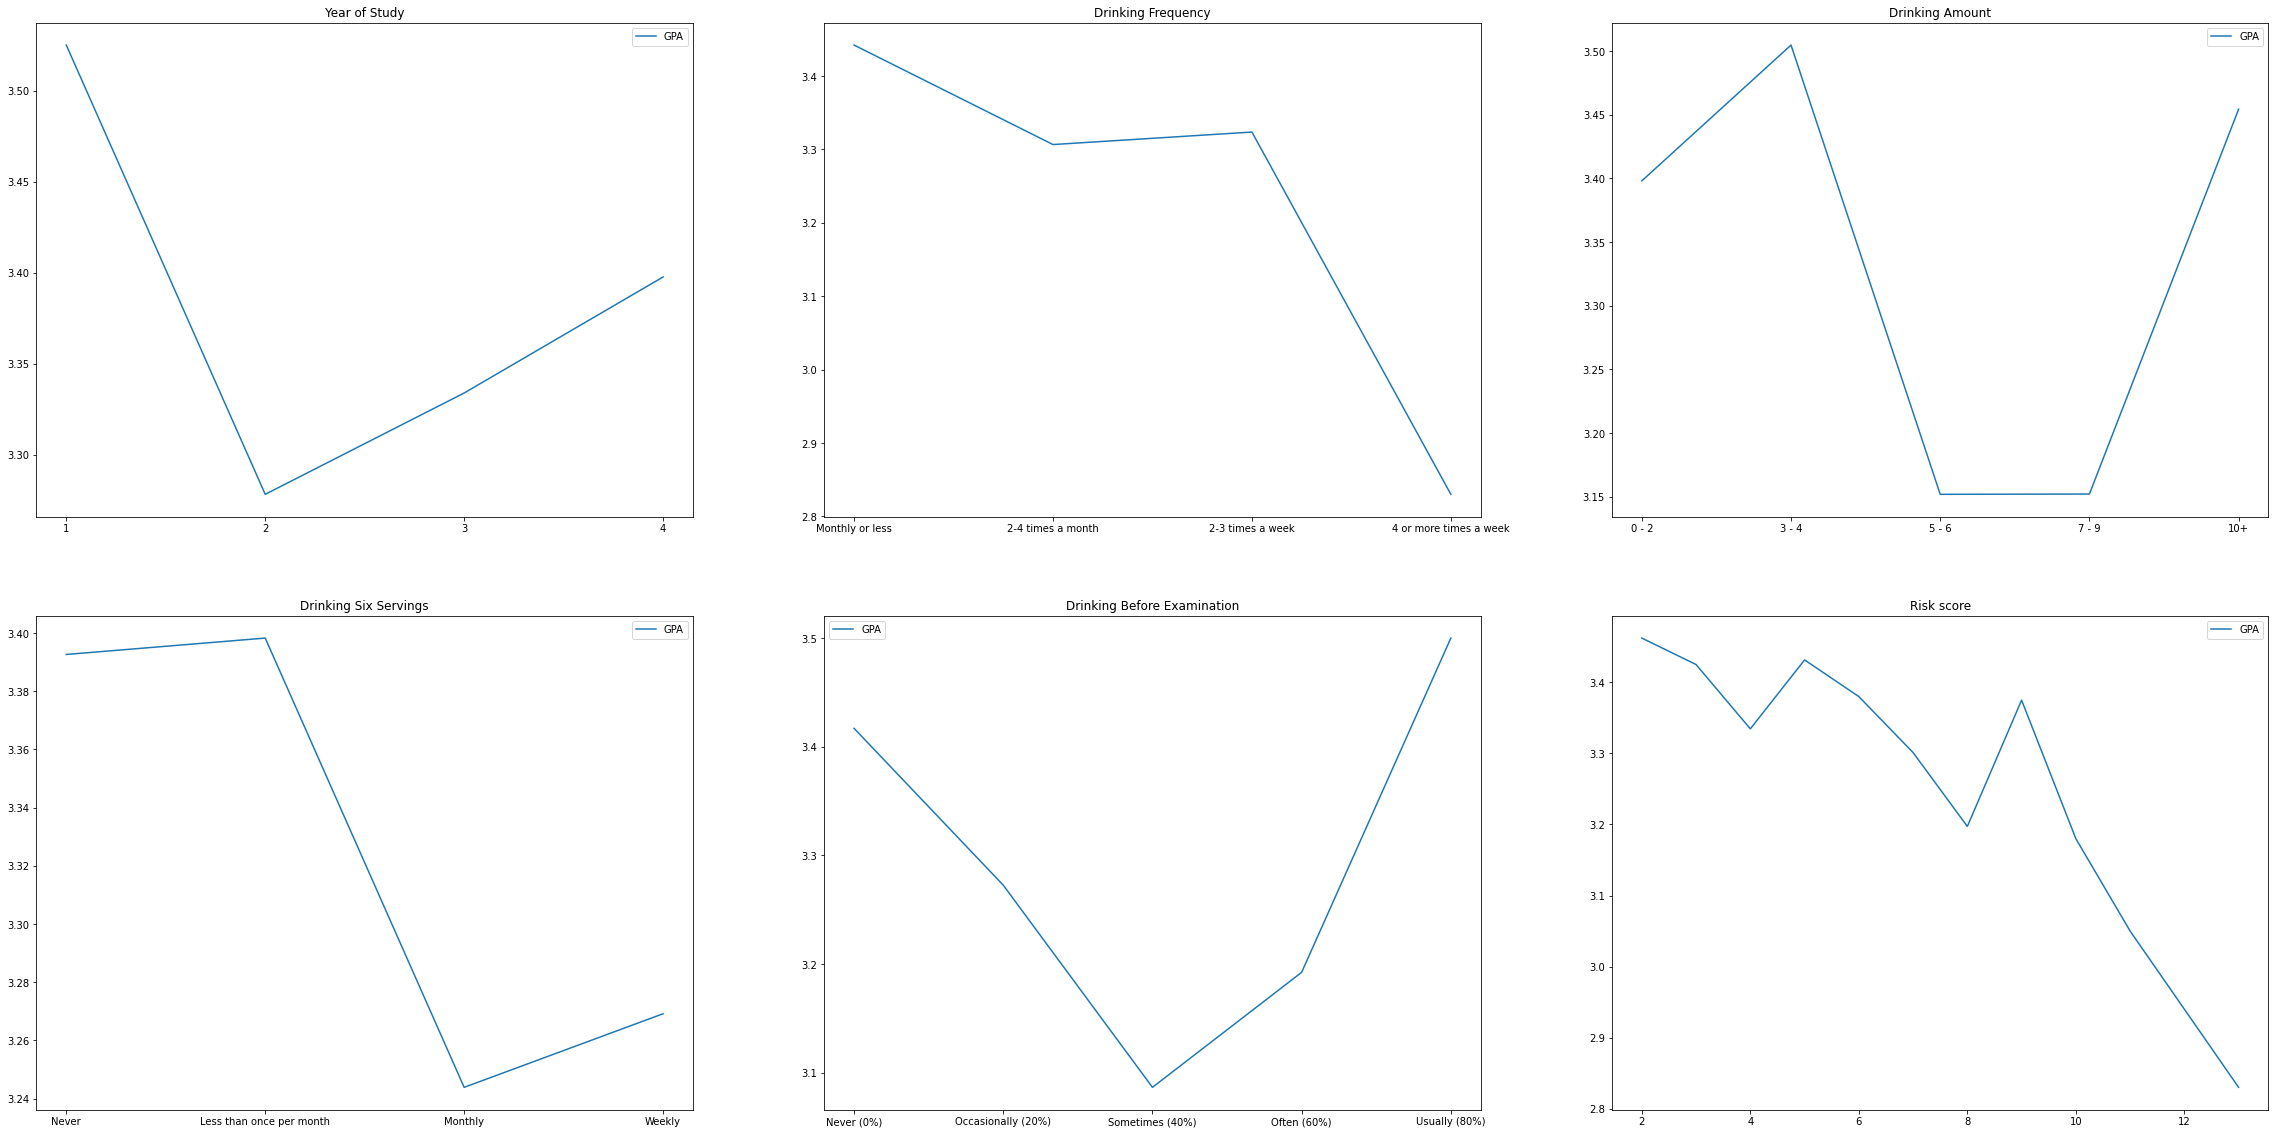

In [13]:
regression_attribute = [
    "year_of_study", "drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score", "drinking_frequency_before_examination_score", "risk_score", 
    "gpa", "activity_1", "activity_2", "academic_achievements", "professional_examinations"
]

df_drinker_quantified_regression = df_drinker_quantified[regression_attribute]
df_drinker_quantified_normalized = (df_drinker_quantified_regression - df_drinker_quantified_regression.min()) / (df_drinker_quantified_regression.max() - df_drinker_quantified_regression.min())

x_columns = ["year_of_study", "drinking_frequency_score", "drinking_consumption_amount_score", "drinking_frequency_six_servings_score", "drinking_frequency_before_examination_score", "risk_score"]

# gpa
linear_regression_gpa = linear_model.LinearRegression()
linear_regression_gpa.fit(df_drinker_quantified[x_columns], df_drinker_quantified["gpa"])
print(linear_regression_gpa.intercept_)
print(linear_regression_gpa.coef_)

plt.figure(figsize=(40, 20))

# year of study
gpa_group_by_year = df_drinker_quantified[["year_of_study", "gpa"]].groupby("year_of_study").mean().reset_index()
plt_year = plt.subplot(2, 3, 1) 
plt.plot(gpa_group_by_year["year_of_study"], gpa_group_by_year["gpa"], label="GPA")
plt.title("Year of Study")
plt.legend()
plt.xticks([1, 2, 3, 4])

# freq
gpa_group_by_freq = df_drinker_quantified[["drinking_frequency_score", "gpa"]].groupby("drinking_frequency_score").mean().reset_index()
plt_freq = plt.subplot(2, 3, 2) 
plt_freq = plt.plot([
    "Monthly or less",
    "2-4 times a month",
    "2-3 times a week",
    "4 or more times a week"
], gpa_group_by_freq["gpa"], label="GPA")
plt.title("Drinking Frequency")


# amount
gpa_group_by_amount = df_drinker_quantified[["drinking_consumption_amount_score", "gpa"]].groupby("drinking_consumption_amount_score").mean().reset_index()
plt_amount = plt.subplot(2, 3, 3) 
plt_amount = plt.plot([
    "0 - 2",
    "3 - 4",
    "5 - 6",
    "7 - 9",
    "10+"
], gpa_group_by_amount["gpa"], label="GPA")
plt.title("Drinking Amount")
plt.legend()

# drinking_frequency_six_servings
gpa_group_by_six_servings = df_drinker_quantified[["drinking_frequency_six_servings_score", "gpa"]].groupby("drinking_frequency_six_servings_score").mean().reset_index()
plt_six_servings = plt.subplot(2, 3, 4) 
plt_six_servings = plt.plot([
        "Never",
        "Less than once per month",
        "Monthly",
        "Weekly",
], gpa_group_by_six_servings["gpa"], label="GPA")
plt.title("Drinking Six Servings")
plt.legend()

# Drinking frequency before exam
gpa_group_drinking_before_exam = df_drinker_quantified[["drinking_frequency_before_examination_score", "gpa"]].groupby("drinking_frequency_before_examination_score").mean().reset_index()
plt_before_exam = plt.subplot(2, 3, 5) 
plt_before_exam = plt.plot([
        "Never (0%)",
        "Occasionally (20%)",
        "Sometimes (40%)",
        "Often (60%)",
        "Usually (80%)",
], gpa_group_drinking_before_exam["gpa"], label="GPA")
plt.title("Drinking Before Examination")
plt.legend()

# Risk score
gpa_group_by_risk_score = df_drinker_quantified[["risk_score", "gpa"]].groupby("risk_score").mean().reset_index()
plt_risk_score = plt.subplot(2, 3, 6) 
plt_risk_score = plt.plot(gpa_group_by_risk_score["risk_score"], gpa_group_by_risk_score["gpa"], label="GPA")
plt.title("Risk score")
plt.legend()

plt.show()